# Classification of whether a person working in tech is willing to seek help for depression or not?

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [5]:
# Load the dataset into a DataFrame
file_path = "C:/Users/Hp/Downloads/survey.csv"
data = pd.read_csv(file_path)

In [6]:
data.head()

Timestamp  Age  Gender         Country state self_employed  \
0  27-08-2014 11:29   37  Female   United States    IL           NaN   
1  27-08-2014 11:29   44       M   United States    IN           NaN   
2  27-08-2014 11:29   32    Male          Canada   NaN           NaN   
3  27-08-2014 11:29   31    Male  United Kingdom   NaN           NaN   
4  27-08-2014 11:30   31    Male   United States    TX           NaN   

  family_history treatment work_interfere    no_employees  ...  \
0             No       Yes          Often          Jun-25  ...   
1             No        No         Rarely  More than 1000  ...   
2             No        No         Rarely          Jun-25  ...   
3            Yes       Yes          Often          26-100  ...   
4             No        No          Never         100-500  ...   

                leave mental_health_consequence phys_health_consequence  \
0       Somewhat easy                        No                      No   
1          Don't know                     Maybe                      No   
2  Somewhat difficult                        No                      No   
3  Somewhat difficult                       Yes                     Yes   
4          Don't know                        No                      No   

      coworkers supervisor mental_health_interview phys_health_interview  \
0  Some of them        Yes                      No                 Maybe   
1            No         No                      No                    No   
2           Yes        Yes                     Yes                   Yes   
3  Some of them         No                   Maybe                 Maybe   
4  Some of them        Yes                     Yes                   Yes   

  mental_vs_physical obs_consequence comments  
0                Yes              No      NaN  
1         Don't know              No      NaN  
2                 No              No      NaN  
3                 No             Yes      NaN  
4         Don't know              No      NaN  

[5 rows x 27 columns]

## Data Preprocessing

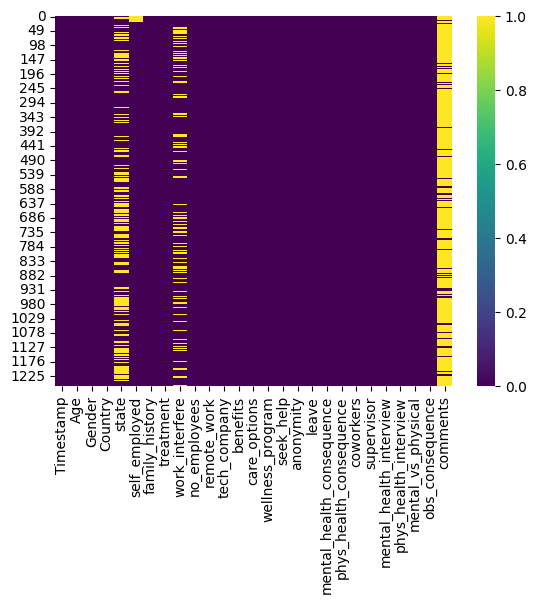

Missing Values Count:
Timestamp                       0
Age                             0
Gender                          0
Country                         0
state                         515
self_employed                  18
family_history                  0
treatment                       0
work_interfere                264
no_employees                    0
remote_work                     0
tech_company                    0
benefits                        0
care_options                    0
wellness_program                0
seek_help                       0
anonymity                       0
leave                           0
mental_health_consequence       0
phys_health_consequence         0
coworkers                       0
supervisor                      0
mental_health_interview         0
phys_health_interview           0
mental_vs_physical              0
obs_consequence                 0
comments                     1095
dtype: int64


In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
# Visualize missing values using a heatmap
sns.heatmap(data.isnull(), cmap='viridis')
plt.show()

# Check for missing values and display the count
missing_values_count = data.isnull().sum()
print("Missing Values Count:")
print(missing_values_count)


In [8]:
# Data preprocessing
# Handle missing values
data.dropna(inplace=True)

## Converting timestamp to datetime format

In [9]:
# Convert 'Timestamp' to datetime format
data['Timestamp'] = pd.to_datetime(data['Timestamp'], errors='coerce', dayfirst=True)

# Extract relevant features
data['Year'] = data['Timestamp'].dt.year
data['Month'] = data['Timestamp'].dt.month
data['Day'] = data['Timestamp'].dt.day
data['Hour'] = data['Timestamp'].dt.hour



## Dropping comments and original timestamp

In [10]:
# Drop the 'comments' column
# Drop original 'Timestamp' column
data.drop(columns=['Timestamp'], inplace=True)
data=data.drop(columns=['comments'])

In [11]:
# Convert 'Gender' to lowercase
data['Gender'] = data['Gender'].str.lower()


In [12]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

# Define remaining categorical columns
remaining_categorical_cols = ['Gender', 'Country', 'state', 'self_employed', 'work_interfere', 
                               'no_employees', 'remote_work', 'tech_company', 'benefits', 
                               'care_options', 'wellness_program', 'seek_help', 'anonymity', 
                               'leave', 'mental_health_consequence', 'phys_health_consequence', 
                               'coworkers', 'supervisor', 'mental_health_interview', 
                               'phys_health_interview', 'mental_vs_physical', 'obs_consequence']

# Encode remaining categorical columns
for col in remaining_categorical_cols:
    data[col] = label_encoder.fit_transform(data[col].astype(str))

# Encode the target variable if necessary
# Example: y_train = label_encoder.fit_transform(y_train.astype(str))


In [13]:
# Convert "Yes" to 1 and "No" to 0 in the "treatment" column
data['treatment'] = data['treatment'].map({'Yes': 1, 'No': 0})

# Check the data type of the "treatment" column
print(data['treatment'].dtype)


int64


In [14]:
# Convert remaining columns to numeric format
for column in data.columns:
    try:
        data[column] = pd.to_numeric(data[column])
    except ValueError:
        pass  

In [15]:
unique_values = data['no_employees'].unique()
print(unique_values)


[2 5 0 4 3 1]


In [16]:
data['family_history'] = data['family_history'].map({'Yes': 1, 'No': 0})


## Identify categorical columns

In [17]:
# Identify categorical columns
categorical_columns = data.select_dtypes(include=['object']).columns

# Apply one-hot encoding to each categorical column
#data = pd.get_dummies(data, columns=categorical_columns)
# Convert categorical variables to numerical using one-hot encoding
data = pd.get_dummies(data, columns=['Gender', 'Country', 'state', 'self_employed', 'treatment', 'work_interfere', 'remote_work', 'tech_company', 'benefits', 'care_options', 'wellness_program', 'anonymity', 'leave', 'mental_health_consequence', 'phys_health_consequence', 'coworkers', 'supervisor', 'mental_health_interview', 'phys_health_interview', 'mental_vs_physical', 'obs_consequence'])


In [18]:
# Visualize correlation matrix
plt.figure(figsize=(200, 195))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [19]:
# Split data into features and target variable
X = data.drop(columns=['seek_help'])
y = data['seek_help']

In [20]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [21]:
# Select only numerical columns for outlier detection using IQR
numerical_cols = X_train.select_dtypes(include=np.number).columns.tolist()
X_train_numerical = X_train[numerical_cols]


In [22]:
# Define bounds for outlier detection
Q1 = X_train_numerical.quantile(0.25)
Q3 = X_train_numerical.quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds for outlier detection
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Apply outlier detection based on the bounds
outlier_mask = ((X_train_numerical < lower_bound) | (X_train_numerical > upper_bound)).any(axis=1)

# Apply outlier removal to retain non-outlier samples
X_train_no_outliers = X_train[~outlier_mask]
y_train_no_outliers = y_train[~outlier_mask]

# Check the shape of X_train_no_outliers to ensure samples remain after removal
print("Shape of X_train_no_outliers:", X_train_no_outliers.shape)


Shape of X_train_no_outliers: (54, 98)


In [23]:
# Remove outliers from training set based on lower and upper bounds
X_train_no_outliers = X_train.clip(lower=lower_bound, upper=upper_bound, axis=1).dropna()
# Double-check the shape of X_train_no_outliers after outlier removal
print("Shape of X_train_no_outliers:", X_train_no_outliers.shape)


Shape of X_train_no_outliers: (0, 98)


In [24]:
# Debugging statements to inspect outlier detection parameters
print("Q1:", Q1)
print("Q3:", Q3)
print("IQR:", IQR)
print("Lower Bound:", lower_bound)
print("Upper Bound:", upper_bound)

# Apply outlier removal based on adjusted bounds
outlier_mask = ((X_train_numerical < lower_bound) | (X_train_numerical > upper_bound)).any(axis=1)
print("Outlier Mask:", outlier_mask)

# Count number of outliers
outliers_count = outlier_mask.sum()
print("Number of Outliers:", outliers_count)

# Filter outliers to get X_train_no_outliers
X_train_no_outliers = X_train[~outlier_mask]
print("Shape of X_train_no_outliers:", X_train_no_outliers.shape)


Q1: Age                 30.00
family_history       0.00
no_employees         1.00
Year              2014.00
Month                8.00
Day                 27.00
Hour                11.75
Name: 0.25, dtype: float64
Q3: Age                 39.25
family_history       1.00
no_employees         4.00
Year              2014.00
Month                8.00
Day                 28.00
Hour                16.00
Name: 0.75, dtype: float64
IQR: Age               9.25
family_history    1.00
no_employees      3.00
Year              0.00
Month             0.00
Day               1.00
Hour              4.25
dtype: float64
Lower Bound: Age                 16.125
family_history      -1.500
no_employees        -3.500
Year              2014.000
Month                8.000
Day                 25.500
Hour                 5.375
dtype: float64
Upper Bound: Age                 53.125
family_history       2.500
no_employees         8.500
Year              2014.000
Month                8.000
Day                 29.500
H

## Random Forest

In [25]:
# Initialize RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state=42)
# Check shapes of X_train_no_outliers and y_train_no_outliers
print("Shape of X_train_no_outliers:", X_train_no_outliers.shape)
print("Shape of y_train_no_outliers:", y_train_no_outliers.shape)

# Train the classifier on the cleaned training data without outliers
try:
    rf_classifier.fit(X_train_no_outliers, y_train_no_outliers)
    print("RandomForestClassifier trained successfully!")
except Exception as e:
    print("Error occurred during model training:", e)

# Train the classifier on the cleaned training data without outliers
rf_classifier.fit(X_train_no_outliers, y_train_no_outliers)


Shape of X_train_no_outliers: (54, 98)
Shape of y_train_no_outliers: (54,)
RandomForestClassifier trained successfully!


RandomForestClassifier(random_state=42)

## Feature Scaling

In [26]:

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_no_outliers)
X_test_scaled = scaler.transform(X_test)

In [27]:
# Define hyperparameters to search
param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


## Perform GridSearchCV

In [28]:
# Perform GridSearchCV
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_no_outliers, y_train_no_outliers)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='accuracy')

In [29]:
# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)
# Train the Random Forest classifier with the best parameters
best_rf_classifier = RandomForestClassifier(**best_params, random_state=42)
best_rf_classifier.fit(X_train_no_outliers, y_train_no_outliers)


Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}


RandomForestClassifier(random_state=42)

In [30]:
# Evaluate performance
y_pred_rf = best_rf_classifier.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf, average='macro')
recall_rf = recall_score(y_test, y_pred_rf, average='macro')
f1_rf = f1_score(y_test, y_pred_rf, average='macro')

print("Random Forest Classifier Metrics:")
print("Accuracy:", accuracy_rf)
print("Precision:", precision_rf)
print("Recall:", recall_rf)
print("F1 Score:", f1_rf)

Random Forest Classifier Metrics:
Accuracy: 0.6666666666666666
Precision: 0.6666666666666666
Recall: 0.6444444444444444
F1 Score: 0.6055555555555555


In [31]:
from sklearn.ensemble import RandomForestClassifier

# Initialize Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Train Random Forest classifier
rf_classifier.fit(X_train, y_train)

# Evaluate Random Forest classifier with cross-validation
rf_cv_scores = cross_val_score(rf_classifier, X_train_no_outliers, y_train_no_outliers, cv=5, scoring='accuracy')
print("Random Forest CV Scores:", rf_cv_scores)
print("Mean CV Accuracy:", rf_cv_scores.mean())


Random Forest CV Scores: [0.45454545 0.63636364 0.54545455 0.45454545 0.8       ]
Mean CV Accuracy: 0.5781818181818181


In [32]:
# Make predictions on the test set
y_pred_rf = rf_classifier.predict(X_test)

# Calculate evaluation metrics
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf, average='macro')
recall_rf = recall_score(y_test, y_pred_rf, average='macro')
f1_rf = f1_score(y_test, y_pred_rf, average='macro')

print("Random Forest Classifier Metrics:")
print("Accuracy:", accuracy_rf)
print("Precision:", precision_rf)
print("Recall:", recall_rf)
print("F1 Score:", f1_rf)

Random Forest Classifier Metrics:
Accuracy: 0.6111111111111112
Precision: 0.611111111111111
Recall: 0.611111111111111
F1 Score: 0.5555555555555555


## Confusion Matrix

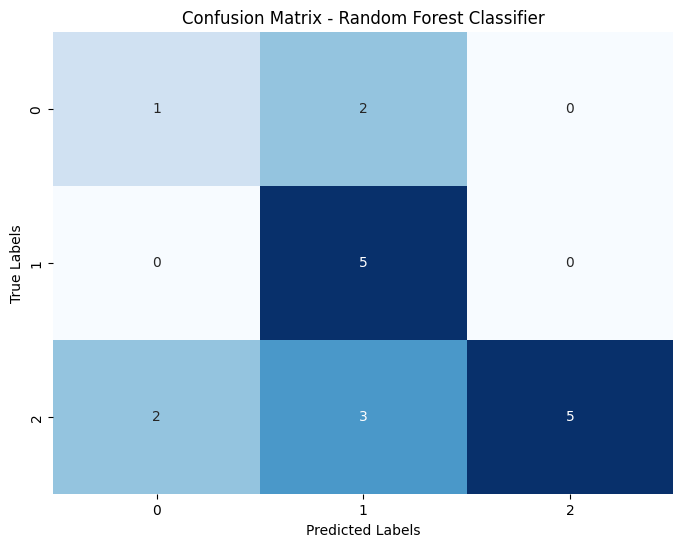

In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.title("Confusion Matrix - Random Forest Classifier")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


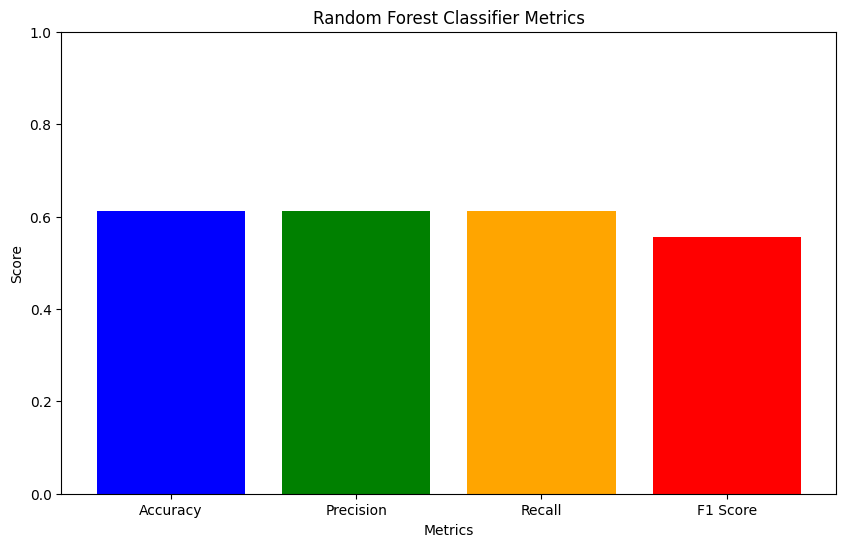

In [34]:
import matplotlib.pyplot as plt

# Metrics names
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

# Metrics values
metrics_values = [accuracy_rf, precision_rf, recall_rf, f1_rf]

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(metrics_names, metrics_values, color=['blue', 'green', 'orange', 'red'])
plt.title('Random Forest Classifier Metrics')
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)  # Set y-axis limit from 0 to 1
plt.show()


In [35]:
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Make predictions on the test set
y_score = rf_classifier.predict_proba(X_test)


# Binarize the labels
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])  # Replace [0, 1, 2] with your actual class labels

# Define the number of classes
num_classes = y_test_bin.shape[1]

# Compute precision and recall for each class
precision = dict()
recall = dict()
for i in range(num_classes):  # Replace num_classes with the number of classes in your dataset
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])  # Replace y_score with the predicted probabilities for each class

# Plot precision-recall curve for each class
plt.figure()
for i in range(num_classes):
    plt.step(recall[i], precision[i], where='post', label=f'Class {i}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()


In [36]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Initialize AdaBoostClassifier with a base estimator (e.g., RandomForestClassifier)
ada_classifier = AdaBoostClassifier(estimator=best_rf_classifier, n_estimators=50, learning_rate=1.0, random_state=42)

# Train AdaBoostClassifier on the cleaned training data without outliers
ada_classifier.fit(X_train_no_outliers, y_train_no_outliers)

# Make predictions on the test set using AdaBoostClassifier
y_pred_ada = ada_classifier.predict(X_test)

# Evaluate performance metrics for AdaBoostClassifier
accuracy_ada = accuracy_score(y_test, y_pred_ada)
precision_ada = precision_score(y_test, y_pred_ada, average='macro')
recall_ada = recall_score(y_test, y_pred_ada, average='macro')
f1_ada = f1_score(y_test, y_pred_ada, average='macro')

# Print AdaBoostClassifier metrics
print("AdaBoost Classifier Metrics:")
print("Accuracy:", accuracy_ada)
print("Precision:", precision_ada)
print("Recall:", recall_ada)
print("F1 Score:", f1_ada)


AdaBoost Classifier Metrics:
Accuracy: 0.7222222222222222
Precision: 0.7407407407407408
Recall: 0.7555555555555555
F1 Score: 0.7103174603174603


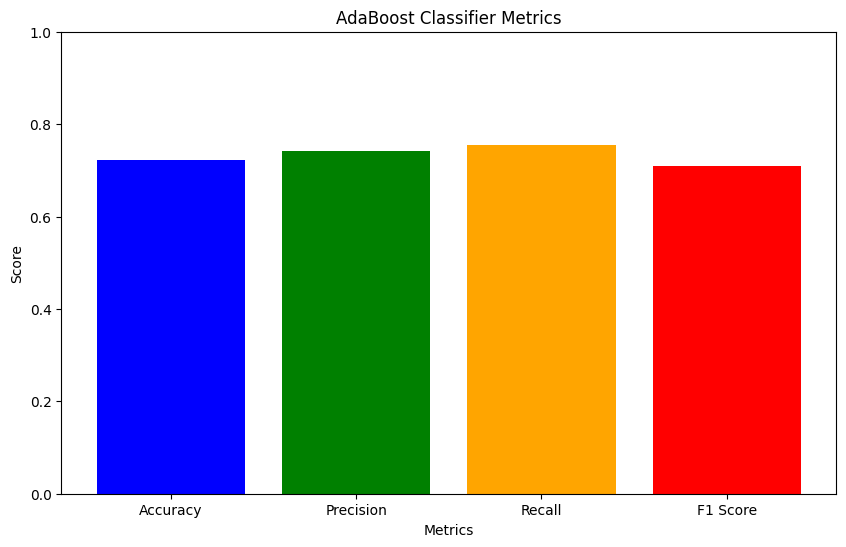

In [37]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion matrix
conf_matrix_ada = confusion_matrix(y_test, y_pred_ada)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_ada, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.title("Confusion Matrix - AdaBoost Classifier")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Plotting AdaBoostClassifier metrics
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
metrics_values = [accuracy_ada, precision_ada, recall_ada, f1_ada]

plt.figure(figsize=(10, 6))
plt.bar(metrics_names, metrics_values, color=['blue', 'green', 'orange', 'red'])
plt.title('AdaBoost Classifier Metrics')
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)  # Set y-axis limit from 0 to 1
plt.show()


In [39]:
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Make predictions on the test set
y_score_ada = ada_classifier.predict_proba(X_test)

# Binarize the labels
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])  # Replace [0, 1, 2] with your actual class labels

# Define the number of classes
num_classes = y_test_bin.shape[1]

# Compute precision and recall for each class
precision = dict()
recall = dict()
for i in range(num_classes):  # Replace num_classes with the number of classes in your dataset
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_score_ada[:, i])  # Replace y_score_ada with the predicted probabilities for each class

# Plot precision-recall curve for each class
plt.figure()
for i in range(num_classes):
    plt.step(recall[i], precision[i], where='post', label=f'Class {i}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve (AdaBoost)')
plt.legend()
plt.show()
